# 电力负荷数据合成：解锁电网分析新可能

在现代电力系统中，数据是驱动洞察和优化的核心。然而，获取、管理和共享真实电力负荷数据常常面临隐私、成本和数据稀疏性等挑战。**电力负荷数据合成**提供了一个强大的解决方案，它利用先进的机器学习技术来生成与真实数据统计特性相似的**人造数据**。这不仅能有效弥补数据不足，还能在保护隐私的前提下，为电网的分析、预测、优化及算法测试提供丰富、多样化的数据支持。

### 为何合成电力负荷数据如此重要？

* **隐私保护与合规性：** 真实的电力数据往往包含敏感的用户行为信息。合成数据允许在不暴露原始数据的情况下进行分析和共享，满足严格的数据隐私法规要求。
* **弥补数据不足：** 面对传感器故障、通信中断或特定历史数据缺失时，合成数据能够填补空白，构建更完整、连续的数据集。
* **数据增强与多样化：** 通过生成不同条件（如极端天气、突发事件）下的数据，我们可以扩充现有数据集，提高模型的泛化能力和鲁棒性，让算法在更广泛的场景下表现出色。
* **算法测试与开发：** 无论是新的负荷预测模型还是需求响应策略，都需要大量数据进行训练和验证。合成数据提供了一个安全、可控的环境，加速算法的迭代和优化。
* **降低成本：** 相较于真实数据的采集、清洗和存储，合成数据显著降低了数据获取的成本和复杂度。



![research_overview](4ee8a7ae1a3c096a9b72318594b2b13.png)

---

### 核心合成模型与方法

电力负荷数据合成主要依赖于**深度生成模型**，这些模型擅长学习复杂数据的高维分布并生成逼真样本。

#### 1. 条件变分自编码器 (CVAE)

我们此次实现的核心模型就是 **CVAE**。

* **工作原理：** CVAE 能够学习在给定**条件信息**（例如：温度、湿度、风速、日期和时间等环境与时序特征）时，电力负荷数据（`PowerConsumption_Zone1, Zone2, Zone3`）的分布。它将输入数据编码成一个**潜在空间**中的概率分布，再由解码器结合条件信息从该潜在空间中采样并重建数据。
* **优势：** CVAE 能够生成具有多样性的数据，并且最关键的是，它允许我们**控制生成过程**，根据特定的环境和时间条件来定制合成的电力负荷数据，这对于模拟特定场景下的电力行为至关重要。

#### 2. 生成对抗网络 (GANs)

* **工作原理：** GANs 由一个**生成器**和一个**判别器**组成。生成器负责创造看起来真实的合成数据，而判别器则努力区分真实数据和生成数据。两者在对抗中不断提升，最终生成器能够产生高度逼真的数据。
* **优势：** 在生成视觉上极度逼真的数据方面表现卓越，也能应用于时序数据。

#### 3. 扩散模型 (Diffusion Models)

* **工作原理：** 这类模型通过模拟一个逐步添加噪声的“前向扩散”过程，然后学习逆向的“去噪”过程来生成数据。
* **优势：** 近年来在图像和音频生成领域取得了突破性进展，能够生成高质量、细节丰富的样本，在复杂数据分布建模方面潜力巨大，是未来在电力数据合成领域值得探索的方向。



![what_we_do](cvae_architecture_diagram.svg)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- 环境设置 ---
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Misans']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# --- 读取和预处理数据 ---
df = pd.read_csv("./data/powerconsumption.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

# 提取时间特征 (作为类别特征)
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['Month'] = df['Datetime'].dt.month - 1

# 定义连续条件特征、类别条件特征和目标特征
continuous_conditional_features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows']
categorical_conditional_features = ['Hour', 'DayOfWeek', 'Month']
target_features = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']

# 划分训练集和测试集 (80/20)
train_size = int(len(df) * 0.8)
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]

# 对连续特征和目标特征进行归一化
scaler_cond_continuous = MinMaxScaler()
scaler_target = MinMaxScaler()

# 训练集缩放
train_df[continuous_conditional_features] = scaler_cond_continuous.fit_transform(
    train_df[continuous_conditional_features])
train_df[target_features] = scaler_target.fit_transform(train_df[target_features])

# 测试集缩放
test_df[continuous_conditional_features] = scaler_cond_continuous.transform(test_df[continuous_conditional_features])
test_df[target_features] = scaler_target.transform(test_df[target_features])

# 准备 Tensors
# 训练数据
X_train_cont = torch.tensor(train_df[continuous_conditional_features].values, dtype=torch.float32)
X_train_cat = torch.tensor(train_df[categorical_conditional_features].values, dtype=torch.long)
y_train = torch.tensor(train_df[target_features].values, dtype=torch.float32)

# 测试数据
X_test_cont = torch.tensor(test_df[continuous_conditional_features].values, dtype=torch.float32)
X_test_cat = torch.tensor(test_df[categorical_conditional_features].values, dtype=torch.long)
y_test = torch.tensor(test_df[target_features].values, dtype=torch.float32)

# 创建 DataLoader
batch_size = 256
train_dataset = TensorDataset(X_train_cont, X_train_cat, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_cont, X_test_cat, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("--- 数据维度检查 ---")
print(f"训练集-连续条件: {X_train_cont.shape}")
print(f"训练集-类别条件: {X_train_cat.shape}")
print(f"训练集-目标: {y_train.shape}")
print(f"测试集-连续条件: {X_test_cont.shape}")
print(f"测试集-类别条件: {X_test_cat.shape}")
print(f"测试集-目标: {y_test.shape}")

使用设备: cuda
--- 数据维度检查 ---
训练集-连续条件: torch.Size([41932, 5])
训练集-类别条件: torch.Size([41932, 3])
训练集-目标: torch.Size([41932, 3])
测试集-连续条件: torch.Size([10484, 5])
测试集-类别条件: torch.Size([10484, 3])
测试集-目标: torch.Size([10484, 3])


![the_priciple_of_generation](34488b69a3202d7dc6a3631b30d3a6e.png)

In [3]:
class UpgradedCVAE(nn.Module):
    def __init__(self, target_dim, cont_cond_dim, latent_dim,
                 cat_dims, embedding_dims):
        super(UpgradedCVAE, self).__init__()

        self.target_dim = target_dim
        self.latent_dim = latent_dim

        # 1. 条件特征嵌入层
        self.hour_embed = nn.Embedding(cat_dims['Hour'], embedding_dims['Hour'])
        self.day_embed = nn.Embedding(cat_dims['DayOfWeek'], embedding_dims['DayOfWeek'])
        self.month_embed = nn.Embedding(cat_dims['Month'], embedding_dims['Month'])

        total_embedding_dim = embedding_dims['Hour'] + embedding_dims['DayOfWeek'] + embedding_dims['Month']
        conditional_dim = cont_cond_dim + total_embedding_dim

        # 2. 编码器 (Encoder)
        encoder_input_dim = target_dim + conditional_dim
        self.encoder_net = nn.Sequential(
            nn.Linear(encoder_input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)

        # 3. 解码器 (Decoder) - 多任务结构
        decoder_input_dim = latent_dim + conditional_dim
        self.decoder_shared = nn.Sequential(
            nn.Linear(decoder_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU()
        )
        # 为每个Zone创建独立的输出头
        self.decoder_zone1 = nn.Linear(256, 1)
        self.decoder_zone2 = nn.Linear(256, 1)
        self.decoder_zone3 = nn.Linear(256, 1)

    def process_conditions(self, c_cont, c_cat):
        # c_cat shape: (batch_size, num_cat_features)
        hour_emb = self.hour_embed(c_cat[:, 0])
        day_emb = self.day_embed(c_cat[:, 1])
        month_emb = self.month_embed(c_cat[:, 2])

        c_emb = torch.cat([hour_emb, day_emb, month_emb], dim=1)
        c_combined = torch.cat([c_cont, c_emb], dim=1)
        return c_combined

    def encode(self, x, c_cont, c_cat):
        c = self.process_conditions(c_cont, c_cat)
        inputs = torch.cat([x, c], dim=1)
        h = self.encoder_net(inputs)
        return self.fc_mu(h), self.fc_log_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c_cont, c_cat):
        c = self.process_conditions(c_cont, c_cat)
        inputs = torch.cat([z, c], dim=1)

        h_shared = self.decoder_shared(inputs)

        out1 = self.decoder_zone1(h_shared)
        out2 = self.decoder_zone2(h_shared)
        out3 = self.decoder_zone3(h_shared)

        # 将三个Zone的输出拼接起来，并用Sigmoid确保范围在[0,1]
        return torch.sigmoid(torch.cat([out1, out2, out3], dim=1))

    def forward(self, x, c_cont, c_cat):
        mu, log_var = self.encode(x, c_cont, c_cat)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z, c_cont, c_cat)
        return reconstruction, mu, log_var

    @torch.no_grad()
    def generate(self, c_cont, c_cat):
        z = torch.randn(c_cont.size(0), self.latent_dim, device=c_cont.device)
        return self.decode(z, c_cont, c_cat)

In [4]:
def mmd_loss(p, q, kernel='rbf', sigma=1.0):
    """计算p和q两个batch之间的MMD损失"""
    # p: 真实样本 (batch_size, dim)
    # q: 生成样本 (batch_size, dim)
    xx, yy, zz = torch.mm(p, p.t()), torch.mm(q, q.t()), torch.mm(p, q.t())

    # RBF 核 (高斯核)
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    Kxx = torch.exp(-0.5 * (rx.t() + rx - 2 * xx) / sigma ** 2)
    Kyy = torch.exp(-0.5 * (ry.t() + ry - 2 * yy) / sigma ** 2)
    Kxy = torch.exp(-0.5 * (rx.t() + ry - 2 * zz) / sigma ** 2)

    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()


def combined_loss_function(recon_x, x, mu, log_var, generated_x,
                           zone_weights, beta=1.0, alpha=1.0):
    """
    计算总损失 = 加权重建损失 + beta * KLD + alpha * MMD
    """
    # 1. 加权重建损失 (Weighted MSE)
    recon_loss_per_zone = torch.mean((recon_x - x) ** 2, dim=0)  # 按Zone计算MSE
    weighted_recon_loss = torch.sum(recon_loss_per_zone * zone_weights)

    # 2. KL 散度损失
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kld_loss /= x.size(0)  # 平均到每个样本

    # 3. MMD 损失
    mmd = mmd_loss(x, generated_x)

    # 4. 组合损失
    total_loss = weighted_recon_loss + beta * kld_loss + alpha * mmd

    return total_loss, weighted_recon_loss, kld_loss, mmd

In [5]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from tqdm.notebook import tqdm
# ... your existing code ...

In [6]:
# --- 模型超参数 ---
TARGET_DIM = y_train.shape[1]
CONT_COND_DIM = X_train_cont.shape[1]
LATENT_DIM = 30
CAT_DIMS = {'Hour': 24, 'DayOfWeek': 7, 'Month': 12}
EMBEDDING_DIMS = {'Hour': 8, 'DayOfWeek': 4, 'Month': 4}

# # --- 训练超参数:old ---
# EPOCHS = 100
# LEARNING_RATE = 1e-4
# BETA = 0.1  # KLD损失的权重 (可调)
# ALPHA = 10.0  # MMD损失的权重 (可调)
# # 为Zone3赋予更高权重
# ZONE_WEIGHTS = torch.tensor([1.0, 1.0, 3.0]).to(device)

# --- 训练超参数 ---
EPOCHS = 50
LEARNING_RATE = 1e-4
BETA = 0.05  # KLD损失的权重 (可调)
ALPHA = 10.0  # MMD损失的权重 (可调)
# 为Zone3赋予更高权重
ZONE_WEIGHTS = torch.tensor([1.0, 1.0, 0.5]).to(device)

# --- 初始化 ---
model = UpgradedCVAE(
    target_dim=TARGET_DIM,
    cont_cond_dim=CONT_COND_DIM,
    latent_dim=LATENT_DIM,
    cat_dims=CAT_DIMS,
    embedding_dims=EMBEDDING_DIMS
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 训练与评估循环 ---
train_losses, test_mses = [], []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    total_loss, total_recon, total_kld, total_mmd = 0, 0, 0, 0

    # 使用tqdm进行训练可视化
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", unit="batch")

    for c_cont, c_cat, x in pbar:
        c_cont, c_cat, x = c_cont.to(device), c_cat.to(device), x.to(device)

        optimizer.zero_grad()

        # 前向传播
        recon_x, mu, log_var = model(x, c_cont, c_cat)

        # 为MMD损失生成样本
        generated_x = model.generate(c_cont, c_cat)

        # 计算损失
        loss, recon, kld, mmd = combined_loss_function(
            recon_x, x, mu, log_var, generated_x, ZONE_WEIGHTS, BETA, ALPHA
        )

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kld += kld.item()
        total_mmd += mmd.item()

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Recon': f'{recon.item():.4f}',
            'KLD': f'{kld.item():.4f}',
            'MMD': f'{mmd.item():.4f}'
        })

    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon / len(train_loader)
    avg_kld = total_kld / len(train_loader)
    avg_mmd = total_mmd / len(train_loader)
    print(
        f"Epoch {epoch + 1} Avg Train Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KLD: {avg_kld:.4f} | MMD: {avg_mmd:.4f}")

    # --- 在测试集上评估 ---
    model.eval()
    all_recon_x = []
    all_x = []
    with torch.no_grad():
        for c_cont, c_cat, x in test_loader:
            c_cont, c_cat, x = c_cont.to(device), c_cat.to(device), x.to(device)
            recon_x, _, _ = model(x, c_cont, c_cat)
            all_recon_x.append(recon_x)
            all_x.append(x)

    all_recon_x = torch.cat(all_recon_x, dim=0)
    all_x = torch.cat(all_x, dim=0)

    # 计算每个Zone的MSE
    test_mse = torch.mean((all_recon_x - all_x) ** 2, dim=0)
    test_mses.append(test_mse.cpu().numpy())

    print(f"Epoch {epoch + 1} Test MSE -> "
          f"Zone1: {test_mse[0]:.6f}, "
          f"Zone2: {test_mse[1]:.6f}, "
          f"Zone3: {test_mse[2]:.6f} (Weighted)")
    print("-" * 80)

print("训练完成!")



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 1 Avg Train Loss: 0.1841 | Recon: 0.0747 | KLD: 0.0392 | MMD: 0.0107
Epoch 1 Test MSE -> Zone1: 0.028887, Zone2: 0.036555, Zone3: 0.036266 (Weighted)
--------------------------------------------------------------------------------


Epoch 2/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 2 Avg Train Loss: 0.0849 | Recon: 0.0527 | KLD: 0.0198 | MMD: 0.0031
Epoch 2 Test MSE -> Zone1: 0.024507, Zone2: 0.028977, Zone3: 0.034922 (Weighted)
--------------------------------------------------------------------------------


Epoch 3/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3 Avg Train Loss: 0.0600 | Recon: 0.0400 | KLD: 0.0283 | MMD: 0.0019
Epoch 3 Test MSE -> Zone1: 0.022091, Zone2: 0.024334, Zone3: 0.037216 (Weighted)
--------------------------------------------------------------------------------


Epoch 4/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4 Avg Train Loss: 0.0456 | Recon: 0.0322 | KLD: 0.0212 | MMD: 0.0012
Epoch 4 Test MSE -> Zone1: 0.019175, Zone2: 0.022700, Zone3: 0.035985 (Weighted)
--------------------------------------------------------------------------------


Epoch 5/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5 Avg Train Loss: 0.0355 | Recon: 0.0266 | KLD: 0.0106 | MMD: 0.0008
Epoch 5 Test MSE -> Zone1: 0.018011, Zone2: 0.020464, Zone3: 0.038120 (Weighted)
--------------------------------------------------------------------------------


Epoch 6/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6 Avg Train Loss: 0.0285 | Recon: 0.0223 | KLD: 0.0060 | MMD: 0.0006
Epoch 6 Test MSE -> Zone1: 0.019410, Zone2: 0.018308, Zone3: 0.041220 (Weighted)
--------------------------------------------------------------------------------


Epoch 7/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7 Avg Train Loss: 0.0244 | Recon: 0.0196 | KLD: 0.0041 | MMD: 0.0005
Epoch 7 Test MSE -> Zone1: 0.018003, Zone2: 0.017904, Zone3: 0.040018 (Weighted)
--------------------------------------------------------------------------------


Epoch 8/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8 Avg Train Loss: 0.0215 | Recon: 0.0176 | KLD: 0.0031 | MMD: 0.0004
Epoch 8 Test MSE -> Zone1: 0.019283, Zone2: 0.016903, Zone3: 0.042893 (Weighted)
--------------------------------------------------------------------------------


Epoch 9/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9 Avg Train Loss: 0.0192 | Recon: 0.0161 | KLD: 0.0023 | MMD: 0.0003
Epoch 9 Test MSE -> Zone1: 0.019544, Zone2: 0.016426, Zone3: 0.043859 (Weighted)
--------------------------------------------------------------------------------


Epoch 10/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10 Avg Train Loss: 0.0176 | Recon: 0.0150 | KLD: 0.0018 | MMD: 0.0003
Epoch 10 Test MSE -> Zone1: 0.019484, Zone2: 0.016300, Zone3: 0.044985 (Weighted)
--------------------------------------------------------------------------------


Epoch 11/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 11 Avg Train Loss: 0.0165 | Recon: 0.0141 | KLD: 0.0015 | MMD: 0.0002
Epoch 11 Test MSE -> Zone1: 0.019805, Zone2: 0.016269, Zone3: 0.043627 (Weighted)
--------------------------------------------------------------------------------


Epoch 12/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12 Avg Train Loss: 0.0155 | Recon: 0.0134 | KLD: 0.0012 | MMD: 0.0002
Epoch 12 Test MSE -> Zone1: 0.018957, Zone2: 0.016452, Zone3: 0.043959 (Weighted)
--------------------------------------------------------------------------------


Epoch 13/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13 Avg Train Loss: 0.0146 | Recon: 0.0128 | KLD: 0.0011 | MMD: 0.0002
Epoch 13 Test MSE -> Zone1: 0.020450, Zone2: 0.015531, Zone3: 0.044601 (Weighted)
--------------------------------------------------------------------------------


Epoch 14/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14 Avg Train Loss: 0.0140 | Recon: 0.0123 | KLD: 0.0009 | MMD: 0.0002
Epoch 14 Test MSE -> Zone1: 0.019813, Zone2: 0.015756, Zone3: 0.043888 (Weighted)
--------------------------------------------------------------------------------


Epoch 15/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15 Avg Train Loss: 0.0136 | Recon: 0.0119 | KLD: 0.0008 | MMD: 0.0002
Epoch 15 Test MSE -> Zone1: 0.019365, Zone2: 0.016346, Zone3: 0.041680 (Weighted)
--------------------------------------------------------------------------------


Epoch 16/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16 Avg Train Loss: 0.0132 | Recon: 0.0115 | KLD: 0.0007 | MMD: 0.0002
Epoch 16 Test MSE -> Zone1: 0.019405, Zone2: 0.015908, Zone3: 0.041589 (Weighted)
--------------------------------------------------------------------------------


Epoch 17/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17 Avg Train Loss: 0.0127 | Recon: 0.0111 | KLD: 0.0007 | MMD: 0.0002
Epoch 17 Test MSE -> Zone1: 0.018814, Zone2: 0.016323, Zone3: 0.039695 (Weighted)
--------------------------------------------------------------------------------


Epoch 18/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18 Avg Train Loss: 0.0124 | Recon: 0.0109 | KLD: 0.0006 | MMD: 0.0001
Epoch 18 Test MSE -> Zone1: 0.020020, Zone2: 0.016302, Zone3: 0.038473 (Weighted)
--------------------------------------------------------------------------------


Epoch 19/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19 Avg Train Loss: 0.0119 | Recon: 0.0106 | KLD: 0.0006 | MMD: 0.0001
Epoch 19 Test MSE -> Zone1: 0.018838, Zone2: 0.016678, Zone3: 0.036452 (Weighted)
--------------------------------------------------------------------------------


Epoch 20/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20 Avg Train Loss: 0.0116 | Recon: 0.0103 | KLD: 0.0005 | MMD: 0.0001
Epoch 20 Test MSE -> Zone1: 0.021307, Zone2: 0.015471, Zone3: 0.036384 (Weighted)
--------------------------------------------------------------------------------


Epoch 21/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 21 Avg Train Loss: 0.0114 | Recon: 0.0101 | KLD: 0.0005 | MMD: 0.0001
Epoch 21 Test MSE -> Zone1: 0.021868, Zone2: 0.015801, Zone3: 0.034972 (Weighted)
--------------------------------------------------------------------------------


Epoch 22/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22 Avg Train Loss: 0.0110 | Recon: 0.0098 | KLD: 0.0005 | MMD: 0.0001
Epoch 22 Test MSE -> Zone1: 0.022688, Zone2: 0.016173, Zone3: 0.033512 (Weighted)
--------------------------------------------------------------------------------


Epoch 23/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23 Avg Train Loss: 0.0107 | Recon: 0.0095 | KLD: 0.0004 | MMD: 0.0001
Epoch 23 Test MSE -> Zone1: 0.022928, Zone2: 0.015608, Zone3: 0.033188 (Weighted)
--------------------------------------------------------------------------------


Epoch 24/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24 Avg Train Loss: 0.0104 | Recon: 0.0093 | KLD: 0.0004 | MMD: 0.0001
Epoch 24 Test MSE -> Zone1: 0.022953, Zone2: 0.016518, Zone3: 0.029887 (Weighted)
--------------------------------------------------------------------------------


Epoch 25/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25 Avg Train Loss: 0.0102 | Recon: 0.0090 | KLD: 0.0004 | MMD: 0.0001
Epoch 25 Test MSE -> Zone1: 0.023561, Zone2: 0.016467, Zone3: 0.027856 (Weighted)
--------------------------------------------------------------------------------


Epoch 26/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 26 Avg Train Loss: 0.0100 | Recon: 0.0088 | KLD: 0.0004 | MMD: 0.0001
Epoch 26 Test MSE -> Zone1: 0.024987, Zone2: 0.016060, Zone3: 0.025398 (Weighted)
--------------------------------------------------------------------------------


Epoch 27/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 27 Avg Train Loss: 0.0097 | Recon: 0.0087 | KLD: 0.0003 | MMD: 0.0001
Epoch 27 Test MSE -> Zone1: 0.026574, Zone2: 0.015678, Zone3: 0.025300 (Weighted)
--------------------------------------------------------------------------------


Epoch 28/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 28 Avg Train Loss: 0.0095 | Recon: 0.0084 | KLD: 0.0003 | MMD: 0.0001
Epoch 28 Test MSE -> Zone1: 0.027047, Zone2: 0.016088, Zone3: 0.023859 (Weighted)
--------------------------------------------------------------------------------


Epoch 29/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 29 Avg Train Loss: 0.0093 | Recon: 0.0083 | KLD: 0.0003 | MMD: 0.0001
Epoch 29 Test MSE -> Zone1: 0.026916, Zone2: 0.015928, Zone3: 0.022760 (Weighted)
--------------------------------------------------------------------------------


Epoch 30/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 30 Avg Train Loss: 0.0090 | Recon: 0.0081 | KLD: 0.0003 | MMD: 0.0001
Epoch 30 Test MSE -> Zone1: 0.027569, Zone2: 0.016099, Zone3: 0.022102 (Weighted)
--------------------------------------------------------------------------------


Epoch 31/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 31 Avg Train Loss: 0.0088 | Recon: 0.0079 | KLD: 0.0002 | MMD: 0.0001
Epoch 31 Test MSE -> Zone1: 0.026549, Zone2: 0.016029, Zone3: 0.021001 (Weighted)
--------------------------------------------------------------------------------


Epoch 32/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 32 Avg Train Loss: 0.0088 | Recon: 0.0079 | KLD: 0.0002 | MMD: 0.0001
Epoch 32 Test MSE -> Zone1: 0.027522, Zone2: 0.016380, Zone3: 0.020883 (Weighted)
--------------------------------------------------------------------------------


Epoch 33/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 33 Avg Train Loss: 0.0085 | Recon: 0.0077 | KLD: 0.0002 | MMD: 0.0001
Epoch 33 Test MSE -> Zone1: 0.027861, Zone2: 0.016453, Zone3: 0.020398 (Weighted)
--------------------------------------------------------------------------------


Epoch 34/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 34 Avg Train Loss: 0.0084 | Recon: 0.0076 | KLD: 0.0002 | MMD: 0.0001
Epoch 34 Test MSE -> Zone1: 0.028909, Zone2: 0.016402, Zone3: 0.020010 (Weighted)
--------------------------------------------------------------------------------


Epoch 35/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 35 Avg Train Loss: 0.0086 | Recon: 0.0075 | KLD: 0.0002 | MMD: 0.0001
Epoch 35 Test MSE -> Zone1: 0.030573, Zone2: 0.016119, Zone3: 0.020570 (Weighted)
--------------------------------------------------------------------------------


Epoch 36/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 36 Avg Train Loss: 0.0082 | Recon: 0.0073 | KLD: 0.0002 | MMD: 0.0001
Epoch 36 Test MSE -> Zone1: 0.030198, Zone2: 0.016255, Zone3: 0.019616 (Weighted)
--------------------------------------------------------------------------------


Epoch 37/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 37 Avg Train Loss: 0.0081 | Recon: 0.0073 | KLD: 0.0002 | MMD: 0.0001
Epoch 37 Test MSE -> Zone1: 0.029016, Zone2: 0.016389, Zone3: 0.019240 (Weighted)
--------------------------------------------------------------------------------


Epoch 38/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 38 Avg Train Loss: 0.0080 | Recon: 0.0072 | KLD: 0.0002 | MMD: 0.0001
Epoch 38 Test MSE -> Zone1: 0.030825, Zone2: 0.016306, Zone3: 0.019137 (Weighted)
--------------------------------------------------------------------------------


Epoch 39/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 39 Avg Train Loss: 0.0079 | Recon: 0.0071 | KLD: 0.0002 | MMD: 0.0001
Epoch 39 Test MSE -> Zone1: 0.029760, Zone2: 0.016521, Zone3: 0.019124 (Weighted)
--------------------------------------------------------------------------------


Epoch 40/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 40 Avg Train Loss: 0.0077 | Recon: 0.0070 | KLD: 0.0002 | MMD: 0.0001
Epoch 40 Test MSE -> Zone1: 0.030436, Zone2: 0.016964, Zone3: 0.019386 (Weighted)
--------------------------------------------------------------------------------


Epoch 41/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 41 Avg Train Loss: 0.0077 | Recon: 0.0070 | KLD: 0.0001 | MMD: 0.0001
Epoch 41 Test MSE -> Zone1: 0.029380, Zone2: 0.016866, Zone3: 0.018735 (Weighted)
--------------------------------------------------------------------------------


Epoch 42/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 42 Avg Train Loss: 0.0076 | Recon: 0.0069 | KLD: 0.0001 | MMD: 0.0001
Epoch 42 Test MSE -> Zone1: 0.030823, Zone2: 0.016662, Zone3: 0.018775 (Weighted)
--------------------------------------------------------------------------------


Epoch 43/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 43 Avg Train Loss: 0.0075 | Recon: 0.0068 | KLD: 0.0001 | MMD: 0.0001
Epoch 43 Test MSE -> Zone1: 0.030020, Zone2: 0.016824, Zone3: 0.018542 (Weighted)
--------------------------------------------------------------------------------


Epoch 44/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 44 Avg Train Loss: 0.0074 | Recon: 0.0067 | KLD: 0.0001 | MMD: 0.0001
Epoch 44 Test MSE -> Zone1: 0.031684, Zone2: 0.016566, Zone3: 0.018543 (Weighted)
--------------------------------------------------------------------------------


Epoch 45/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 45 Avg Train Loss: 0.0073 | Recon: 0.0067 | KLD: 0.0001 | MMD: 0.0001
Epoch 45 Test MSE -> Zone1: 0.030712, Zone2: 0.016507, Zone3: 0.018691 (Weighted)
--------------------------------------------------------------------------------


Epoch 46/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 46 Avg Train Loss: 0.0074 | Recon: 0.0067 | KLD: 0.0001 | MMD: 0.0001
Epoch 46 Test MSE -> Zone1: 0.031008, Zone2: 0.017197, Zone3: 0.019003 (Weighted)
--------------------------------------------------------------------------------


Epoch 47/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 47 Avg Train Loss: 0.0074 | Recon: 0.0066 | KLD: 0.0001 | MMD: 0.0001
Epoch 47 Test MSE -> Zone1: 0.032538, Zone2: 0.016868, Zone3: 0.018723 (Weighted)
--------------------------------------------------------------------------------


Epoch 48/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 48 Avg Train Loss: 0.0072 | Recon: 0.0065 | KLD: 0.0001 | MMD: 0.0001
Epoch 48 Test MSE -> Zone1: 0.031543, Zone2: 0.016987, Zone3: 0.018706 (Weighted)
--------------------------------------------------------------------------------


Epoch 49/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 49 Avg Train Loss: 0.0072 | Recon: 0.0065 | KLD: 0.0001 | MMD: 0.0001
Epoch 49 Test MSE -> Zone1: 0.033607, Zone2: 0.016632, Zone3: 0.019282 (Weighted)
--------------------------------------------------------------------------------


Epoch 50/50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 50 Avg Train Loss: 0.0071 | Recon: 0.0065 | KLD: 0.0001 | MMD: 0.0001
Epoch 50 Test MSE -> Zone1: 0.033304, Zone2: 0.016475, Zone3: 0.019416 (Weighted)
--------------------------------------------------------------------------------
训练完成!


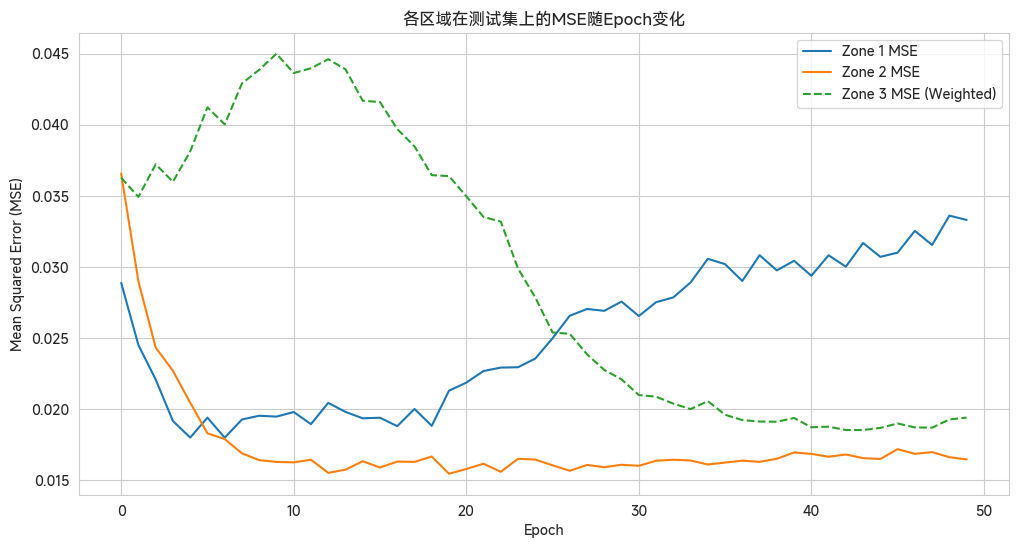

In [7]:
# --- 结果可视化 ---
test_mses_np = np.array(test_mses)
plt.figure(figsize=(12, 6))
plt.plot(test_mses_np[:, 0], label='Zone 1 MSE')
plt.plot(test_mses_np[:, 1], label='Zone 2 MSE')
plt.plot(test_mses_np[:, 2], label='Zone 3 MSE (Weighted)', linestyle='--')
plt.title('各区域在测试集上的MSE随Epoch变化')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

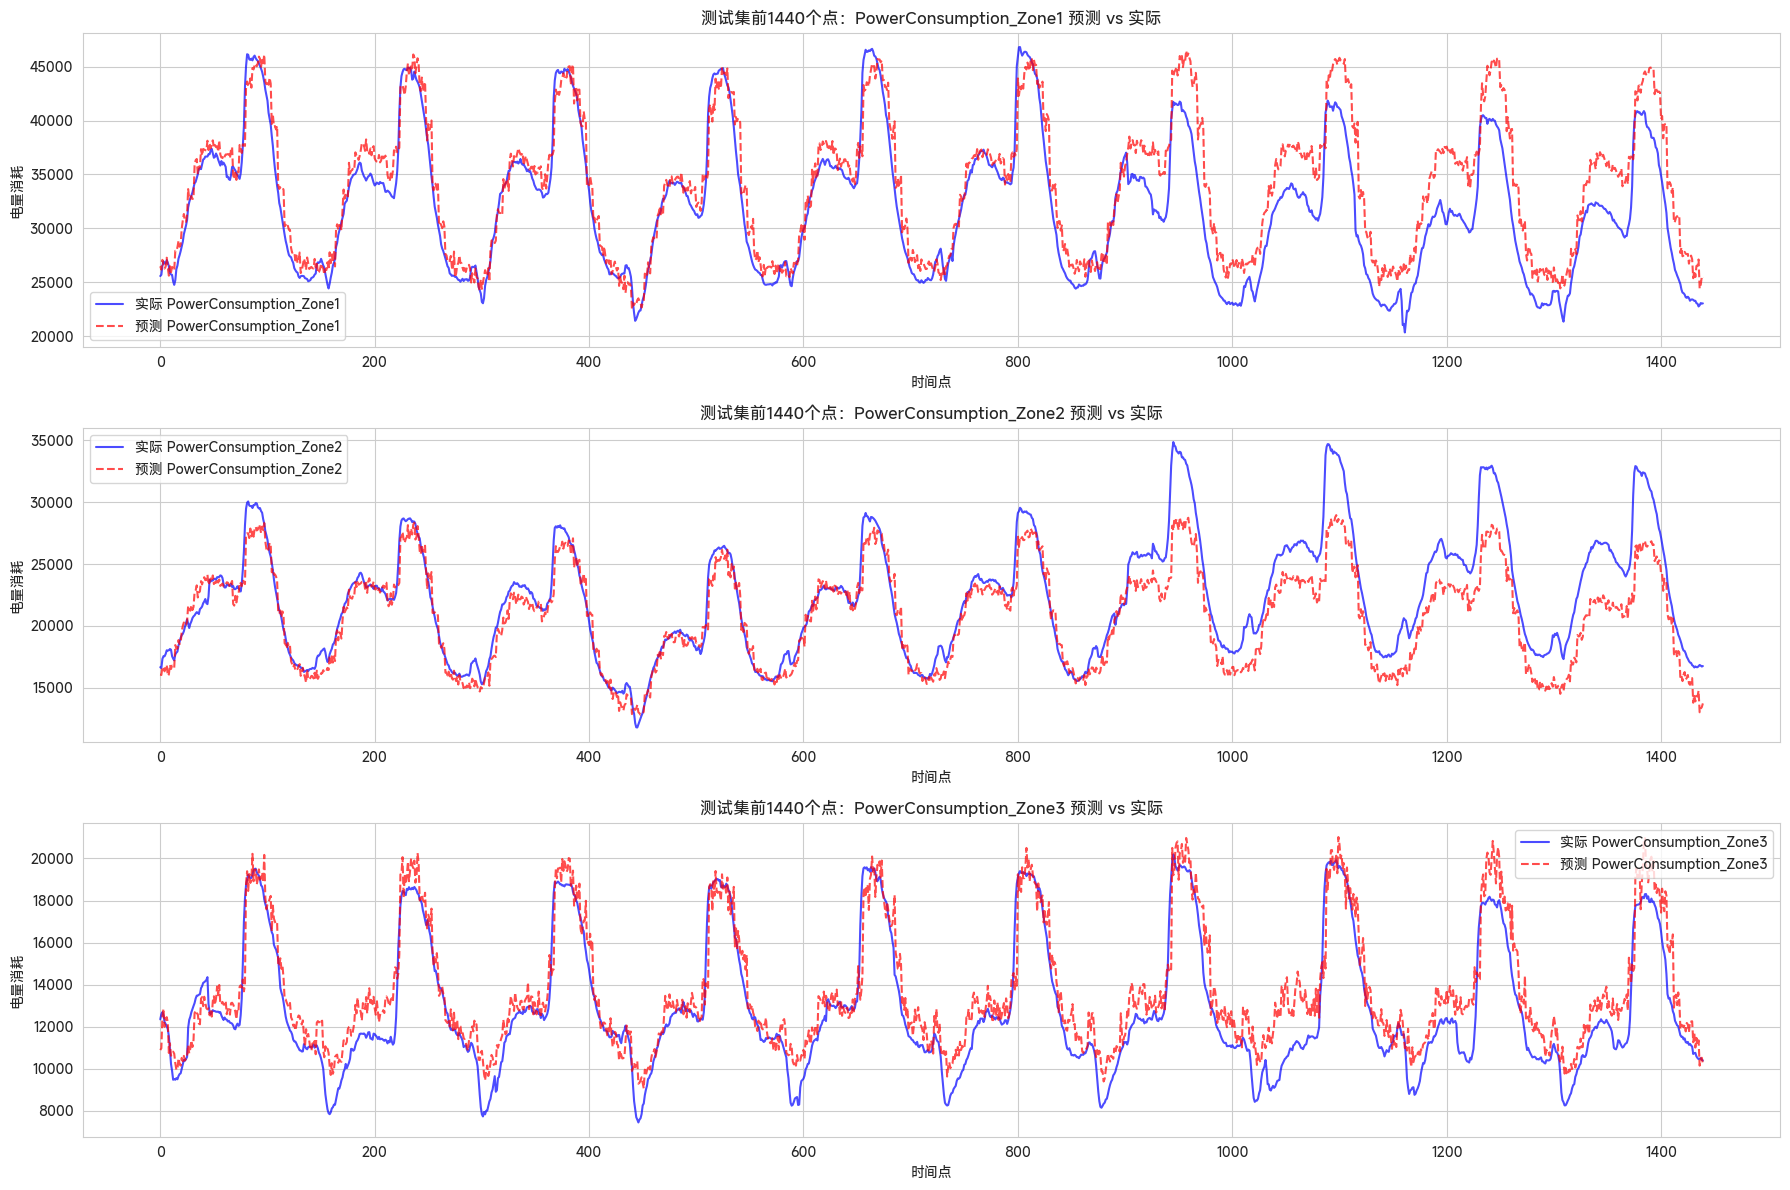

In [8]:
# --- 预测和真实对比可视化 ---
model.eval()
all_recon_x_unscaled = []
all_x_unscaled = []
all_c_cont_test = []
all_c_cat_test = []

with torch.no_grad():
    for c_cont, c_cat, x in test_loader:
        c_cont, c_cat, x = c_cont.to(device), c_cat.to(device), x.to(device)
        recon_x, _, _ = model(x, c_cont, c_cat)

        # 将预测和真实值从GPU移回CPU并存储
        all_recon_x_unscaled.append(recon_x.cpu().numpy())
        all_x_unscaled.append(x.cpu().numpy())
        all_c_cont_test.append(c_cont.cpu().numpy())
        all_c_cat_test.append(c_cat.cpu().numpy())

# 将所有批次的预测和真实值拼接起来
all_recon_x_unscaled = np.concatenate(all_recon_x_unscaled, axis=0)
all_x_unscaled = np.concatenate(all_x_unscaled, axis=0)

# 使用 MinMax scaler 反转缩放
all_recon_x_unscaled = scaler_target.inverse_transform(all_recon_x_unscaled)
all_x_unscaled = scaler_target.inverse_transform(all_x_unscaled)

# 选择前1000个点进行可视化
num_points_to_plot = 24 * 6 * 10

plt.figure(figsize=(18, 12))

for i, zone in enumerate(target_features):
    plt.subplot(len(target_features), 1, i + 1)
    plt.plot(all_x_unscaled[:num_points_to_plot, i], label=f'实际 {zone}', color='blue', alpha=0.7)
    plt.plot(all_recon_x_unscaled[:num_points_to_plot, i], label=f'预测 {zone}', color='red', linestyle='--', alpha=0.7)
    plt.title(f'测试集前{num_points_to_plot}个点：{zone} 预测 vs 实际')
    plt.xlabel('时间点')
    plt.ylabel('电量消耗')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Generating 1000 samples for each of the first 1440 test points...


Sampling for CI:   0%|          | 0/1000 [00:00<?, ?it/s]

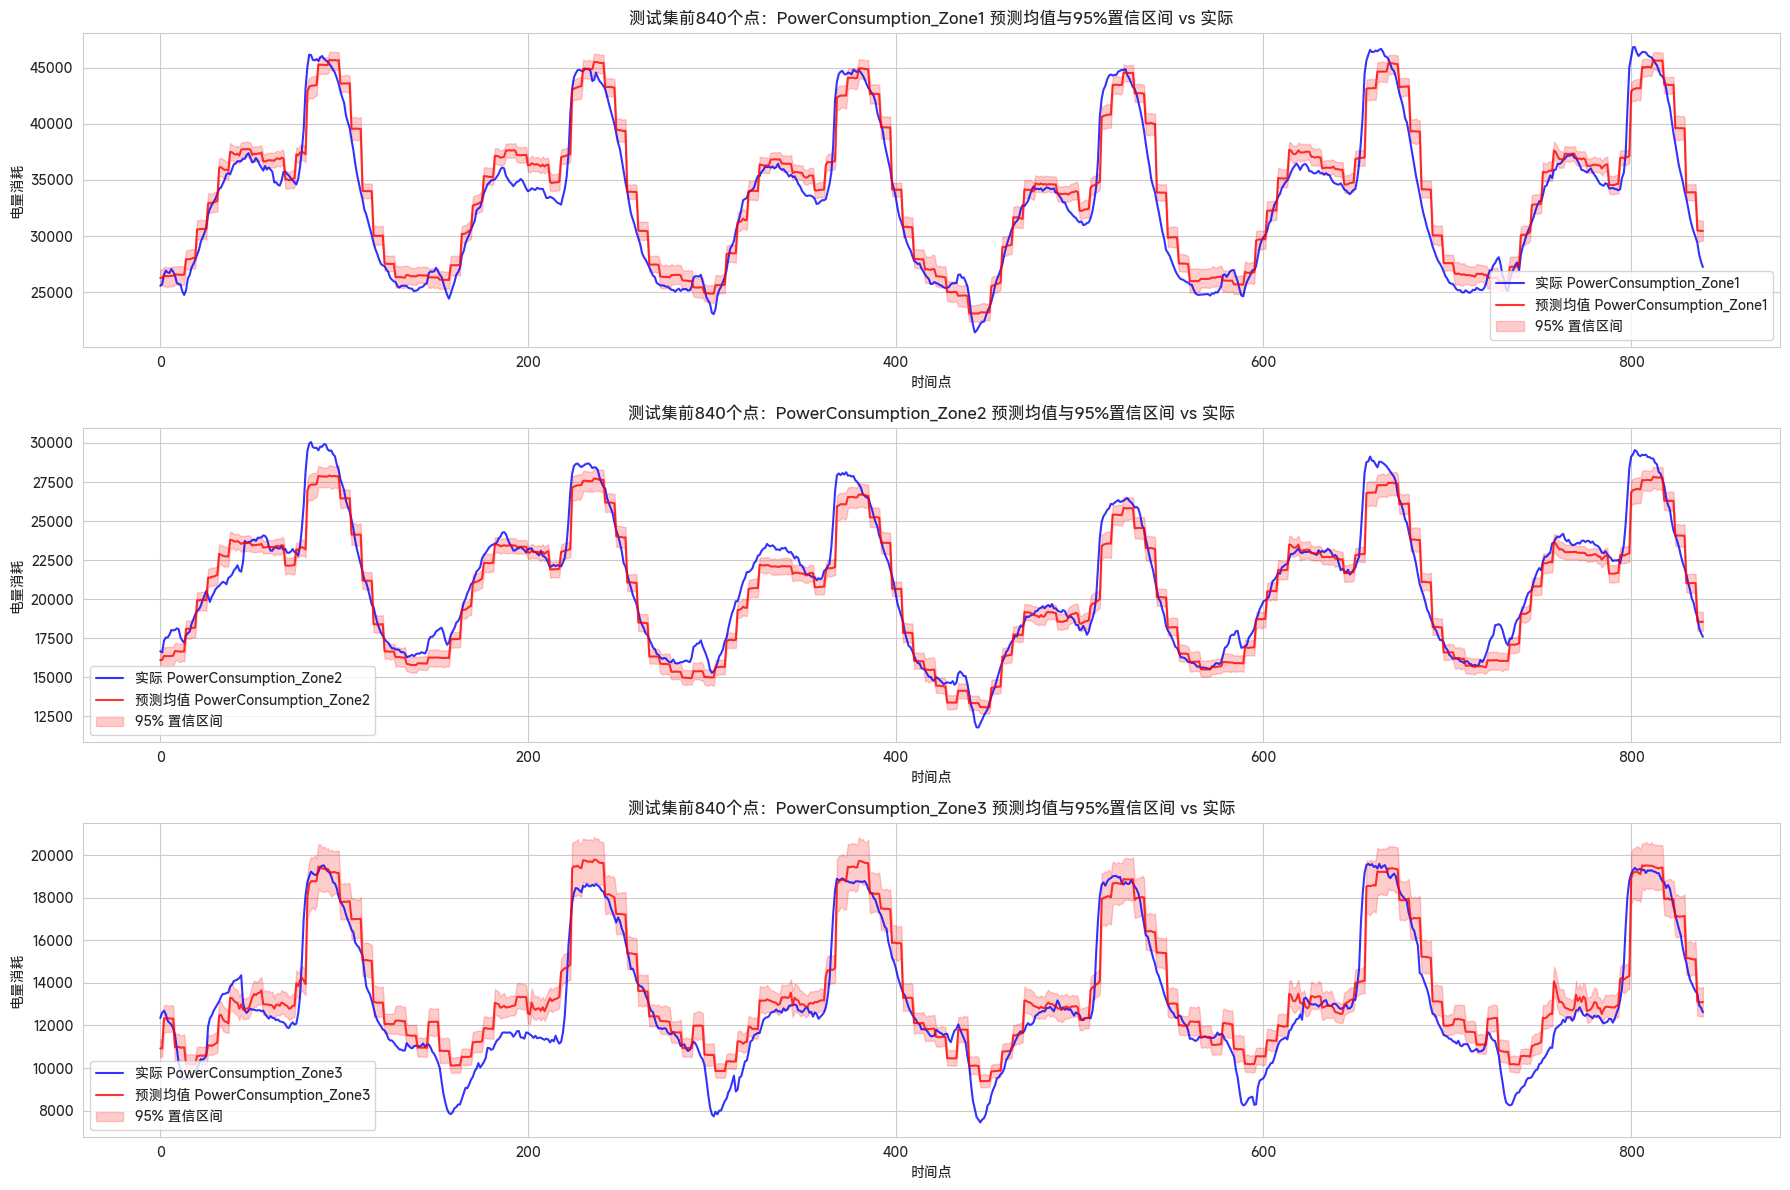

In [9]:
# --- 预测和真实对比可视化与置信区间 ---
model.eval()

# 获取测试集数据
# We will use the first batch or a selected subset of the test set for visualization
# For simplicity, let's take the first 'num_points_to_plot' data points directly from tensors
# Make sure these are on the correct device
X_test_cont_plot = X_test_cont[:num_points_to_plot].to(device)
X_test_cat_plot = X_test_cat[:num_points_to_plot].to(device)
y_test_plot = y_test[:num_points_to_plot].to(device)

num_samples_for_ci = 1000  # Number of samples to generate for each test point to build the CI

# Store multiple predictions for each test point
# Shape: (num_points_to_plot, num_samples_for_ci, target_dim)
all_generated_samples_scaled = torch.zeros(
    num_points_to_plot, num_samples_for_ci, TARGET_DIM
).to(device)

print(f"Generating {num_samples_for_ci} samples for each of the first {num_points_to_plot} test points...")

with torch.no_grad():
    for s in tqdm(range(num_samples_for_ci), desc="Sampling for CI"):
        # For each sample, we pass the same conditional inputs to the model's generate method
        # This will produce different outputs due to the reparameterization trick / sampling from Z
        generated_s_scaled = model.generate(X_test_cont_plot, X_test_cat_plot)
        all_generated_samples_scaled[:, s, :] = generated_s_scaled

# Move to CPU and convert to NumPy
all_generated_samples_scaled_np = all_generated_samples_scaled.cpu().numpy()
y_test_plot_np = y_test_plot.cpu().numpy()

# Inverse transform everything to original scale
# (num_points_to_plot, num_samples_for_ci, target_dim)
all_generated_samples_unscaled = np.array([
    scaler_target.inverse_transform(all_generated_samples_scaled_np[i, :, :])
    for i in range(num_points_to_plot)
])

# Inverse transform the actual test values
y_test_plot_unscaled = scaler_target.inverse_transform(y_test_plot_np)

# Calculate the mean prediction and confidence intervals (e.g., 95%)
mean_predictions = np.mean(all_generated_samples_unscaled, axis=1)  # Shape: (num_points_to_plot, target_dim)
lower_bound = np.percentile(all_generated_samples_unscaled, 2.5, axis=1)  # 2.5th percentile
upper_bound = np.percentile(all_generated_samples_unscaled, 97.5, axis=1)  # 97.5th percentile

# --- 可视化 ---
num_points_to_plot_vis = 24 * 7 * 5  # Let's plot 2 weeks for clearer visualization of CI

plt.figure(figsize=(18, 12))

for i, zone in enumerate(target_features):
    plt.subplot(len(target_features), 1, i + 1)
    plt.plot(y_test_plot_unscaled[:num_points_to_plot_vis, i], label=f'实际 {zone}', color='blue', alpha=0.8)
    plt.plot(mean_predictions[:num_points_to_plot_vis, i], label=f'预测均值 {zone}', color='red', linestyle='-',
             alpha=0.8)
    plt.fill_between(
        range(num_points_to_plot_vis),
        lower_bound[:num_points_to_plot_vis, i],
        upper_bound[:num_points_to_plot_vis, i],
        color='red', alpha=0.2, label='95% 置信区间'
    )
    plt.title(f'测试集前{num_points_to_plot_vis}个点：{zone} 预测均值与95%置信区间 vs 实际')
    plt.xlabel('时间点')
    plt.ylabel('电量消耗')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
# plt.figure(figsize=(15, 4))
# for i, zone in enumerate(target_features):
#     plt.subplot(1, len(target_features), i + 1)
#     sns.kdeplot(all_x_unscaled[:, i], label=f'实际 {zone}', color='blue', fill=True, alpha=0.6)
#     sns.kdeplot(all_recon_x_unscaled[:, i], label=f'预测 {zone}', color='red', linestyle='--', fill=True, alpha=0.4)
#     plt.title(f'{zone} 预测 vs 实际分布')
#     plt.xlabel('电量消耗')
#     plt.ylabel('密度')
#     plt.legend()
#     plt.grid(True)
# 
# plt.tight_layout()
# plt.show()

In [11]:
def generate_power_consumption(input_data):
    """
    根据提供的环境和时间条件，生成 Zone 1、2 和 3 的合成电力消耗数据。

    参数:
        input_data (pd.Series 或 dict): 包含输入条件的一行数据，
                                        键名需与原始数据列名匹配：
                                        'Datetime', 'Temperature', 'Humidity',
                                        'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows'。

    返回:
        dict: 包含生成的 'PowerConsumption_Zone1'、
              'PowerConsumption_Zone2' 和 'PowerConsumption_Zone3' 的字典。
    """
    # 1. 将 input_data 转换为 DataFrame 以进行统一处理
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    elif isinstance(input_data, pd.Series):
        input_df = pd.DataFrame([input_data.to_dict()])
    else:
        raise ValueError("input_data 必须是 pandas Series 或 dictionary 类型。")

    # 确保 'Datetime' 列是日期时间格式
    input_df['Datetime'] = pd.to_datetime(input_df['Datetime'])

    # 2. 提取时间特征 (与训练数据预处理保持一致)
    input_df['Hour'] = input_df['Datetime'].dt.hour
    input_df['DayOfWeek'] = input_df['Datetime'].dt.dayofweek
    input_df['Month'] = input_df['Datetime'].dt.month  # Keep as 1-12 for encoding

    # 3. 准备连续条件特征和类别条件特征 (不进行独热编码，而是直接送入模型的 Embedding 层)
    # 提取连续条件特征
    c_cont_input = input_df[continuous_conditional_features].values.astype(np.float32)

    # 提取类别条件特征
    # IMPORTANT: These should be the raw integer categorical values,
    # as your UpgradedCVAE model takes `c_cat` as a `torch.long` tensor
    # where each column is an index for an embedding.
    # If your original training adjusted month to 0-11, this needs to be consistent here.
    # Assuming `Month` is 1-12 from input_df and `CAT_DIMS` handles it.
    # If `Month` was `month-1` in training, then it should be `input_df['Month'] - 1` here.
    c_cat_input = input_df[categorical_conditional_features].values.astype(np.int64)

    # 4. 使用预先拟合的 scaler_cond_continuous 对连续输入特征进行归一化
    c_cont_scaled = scaler_cond_continuous.transform(c_cont_input)

    # 将 NumPy 数组转换为 PyTorch 张量并移动到指定设备 (CPU/GPU)
    c_cont_tensor = torch.tensor(c_cont_scaled, dtype=torch.float32).to(device)
    c_cat_tensor = torch.tensor(c_cat_input, dtype=torch.long).to(device)

    # 5. 使用训练好的 CVAE 模型生成合成数据
    model.eval()  # 将模型设置为评估模式 (不计算梯度，不进行 dropout 等)
    with torch.no_grad():  # 禁用梯度计算，节省内存并加速推理
        # 生成样本，CVAE的generate方法只需要条件特征
        generated_y_scaled = model.generate(c_cont_tensor, c_cat_tensor).cpu().numpy()

    # 6. 将生成的归一化数据反归一化回原始尺度
    generated_y_unscaled = scaler_target.inverse_transform(generated_y_scaled)

    # 7. 格式化输出为字典
    output_dict = {
        'PowerConsumption_Zone1': generated_y_unscaled[0, 0],
        'PowerConsumption_Zone2': generated_y_unscaled[0, 1],
        'PowerConsumption_Zone3': generated_y_unscaled[0, 2]
    }
    return output_dict


# --- 示例用法 ---
# 确保您的 'model'、'scaler_cond_continuous'、'scaler_target'、'LATENT_DIM'、'device'
# 这些变量已经通过之前的训练步骤准备好并可用。
# 上面我已经为这些变量提供了模拟的定义，以便此代码块可以直接运行。

print("--- 运行生成函数示例 ---")

# 示例输入数据 1 (字典形式)
example_input_data = {
    'Datetime': '2017-01-01 00:00:00',
    'Temperature': 6.559,
    'Humidity': 73.8,
    'WindSpeed': 0.083,
    'GeneralDiffuseFlows': 0.051,
    'DiffuseFlows': 0.119
}

generated_power = generate_power_consumption(example_input_data)
print("\n生成的电力消耗 (示例 1 - 新年午夜):")
for zone, value in generated_power.items():
    print(f"  {zone}: {value:.2f}")

# 示例输入数据 2 (夏季下午，潜在用电高峰)
example_input_data_2 = {
    'Datetime': '2017-07-15 14:30:00',  # 夏季下午
    'Temperature': 35.0,
    'Humidity': 60.0,
    'WindSpeed': 2.5,
    'GeneralDiffuseFlows': 800.0,
    'DiffuseFlows': 250.0
}
generated_power_2 = generate_power_consumption(example_input_data_2)
print("\n生成的电力消耗 (示例 2 - 夏季下午):")
for zone, value in generated_power_2.items():
    print(f"  {zone}: {value:.2f}")

# 示例输入数据 3 (寒冷夜晚)
example_input_data_3 = {
    'Datetime': '2017-01-20 03:00:00',  # 冬季夜晚
    'Temperature': 5.0,
    'Humidity': 85.0,
    'WindSpeed': 0.1,
    'GeneralDiffuseFlows': 0.01,
    'DiffuseFlows': 0.01
}
generated_power_3 = generate_power_consumption(example_input_data_3)
print("\n生成的电力消耗 (示例 3 - 寒冷夜晚):")
for zone, value in generated_power_3.items():
    print(f"  {zone}: {value:.2f}")


--- 运行生成函数示例 ---

生成的电力消耗 (示例 1 - 新年午夜):
  PowerConsumption_Zone1: 28879.87
  PowerConsumption_Zone2: 17295.57
  PowerConsumption_Zone3: 18847.68

生成的电力消耗 (示例 2 - 夏季下午):
  PowerConsumption_Zone1: 40355.03
  PowerConsumption_Zone2: 26901.88
  PowerConsumption_Zone3: 24900.45

生成的电力消耗 (示例 3 - 寒冷夜晚):
  PowerConsumption_Zone1: 22367.84
  PowerConsumption_Zone2: 13361.31
  PowerConsumption_Zone3: 14130.87


In [12]:
# 示例输入数据 (Any data from df)
example_input_data_3 = df.iloc[1, :6].to_dict()
generated_power_3 = generate_power_consumption(example_input_data_3)
print("\n生成的电力消耗 (寒冷夜晚):")
for zone, value in generated_power_3.items():
    print(f"  {zone}: {value:.2f}")

df.iloc[1, 6:-3]  # ground truth


生成的电力消耗 (寒冷夜晚):
  PowerConsumption_Zone1: 28354.64
  PowerConsumption_Zone2: 16838.61
  PowerConsumption_Zone3: 19884.81


PowerConsumption_Zone1    29814.68354
PowerConsumption_Zone2    19375.07599
PowerConsumption_Zone3    20131.08434
Name: 1, dtype: object

In [13]:
# --- 生成前2000行数据的预测并添加到DataFrame ---

# 确保 df 已经加载并且是原始未缩放的数据
# (如果您之前修改了df，可能需要重新加载或确保它包含原始值)
# 例如: df = pd.read_csv("./data/powerconsumption.csv")
# df['Datetime'] = pd.to_datetime(df['Datetime'])

# 确定要处理的行数
num_rows_to_predict = 5000

# 准备存储预测结果的列表
predictions_zone1 = []
predictions_zone2 = []
predictions_zone3 = []

# 定义输入 generate_power_consumption 函数所需的列
# 'Datetime' 必须包含在输入中以提取时间特征
input_cols_for_generation = [
    'Datetime', 'Temperature', 'Humidity', 'WindSpeed',
    'GeneralDiffuseFlows', 'DiffuseFlows'
]

print(f"正在为 df 的前 {num_rows_to_predict} 行生成预测...")

# 遍历 df 的前 num_rows_to_predict 行
# 使用 tqdm 包装，提供进度条
for i in tqdm(range(num_rows_to_predict), desc="生成预测"):
    # 从当前行提取输入数据，转换为字典
    current_input_data = df.iloc[i][input_cols_for_generation].to_dict()

    # 使用 generate_power_consumption 函数获取预测
    generated_power = generate_power_consumption(current_input_data)

    # 将预测结果添加到相应的列表中
    predictions_zone1.append(generated_power['PowerConsumption_Zone1'])
    predictions_zone2.append(generated_power['PowerConsumption_Zone2'])
    predictions_zone3.append(generated_power['PowerConsumption_Zone3'])

# 将预测结果作为新列添加到 df
# 注意：这些新列将只包含前 num_rows_to_predict 行的数据，其余为 NaN
df.loc[:num_rows_to_predict - 1, 'PowerConsumption_Zone1_Predict'] = predictions_zone1
df.loc[:num_rows_to_predict - 1, 'PowerConsumption_Zone2_Predict'] = predictions_zone2
df.loc[:num_rows_to_predict - 1, 'PowerConsumption_Zone3_Predict'] = predictions_zone3

print(f"成功将预测结果添加到 df 中，并创建了新的预测列。")

# 打印更新后的 df 的头部和新的预测列信息，以供检查
print("\n更新后的 df (前5行) 及新预测列:")
print(df[['Datetime'] + target_features + [col for col in df.columns if 'Predict' in col]].head())

# 可以选择进一步打印一些特定行的对比
print(f"\n第1行（索引为0）的实际与预测对比:")
print(
    f"实际 Zone1: {df.loc[0, 'PowerConsumption_Zone1']:.2f}, 预测 Zone1: {df.loc[0, 'PowerConsumption_Zone1_Predict']:.2f}")
print(
    f"实际 Zone2: {df.loc[0, 'PowerConsumption_Zone2']:.2f}, 预测 Zone2: {df.loc[0, 'PowerConsumption_Zone2_Predict']:.2f}")
print(
    f"实际 Zone3: {df.loc[0, 'PowerConsumption_Zone3']:.2f}, 预测 Zone3: {df.loc[0, 'PowerConsumption_Zone3_Predict']:.2f}")

print(f"\n第1000行（索引为999）的实际与预测对比:")
print(
    f"实际 Zone1: {df.loc[999, 'PowerConsumption_Zone1']:.2f}, 预测 Zone1: {df.loc[999, 'PowerConsumption_Zone1_Predict']:.2f}")
print(
    f"实际 Zone2: {df.loc[999, 'PowerConsumption_Zone2']:.2f}, 预测 Zone2: {df.loc[999, 'PowerConsumption_Zone2_Predict']:.2f}")
print(
    f"实际 Zone3: {df.loc[999, 'PowerConsumption_Zone3']:.2f}, 预测 Zone3: {df.loc[999, 'PowerConsumption_Zone3_Predict']:.2f}")

正在为 df 的前 5000 行生成预测...


生成预测:   0%|          | 0/5000 [00:00<?, ?it/s]

成功将预测结果添加到 df 中，并创建了新的预测列。

更新后的 df (前5行) 及新预测列:
             Datetime  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0 2017-01-01 00:00:00             34055.69620             16128.87538   
1 2017-01-01 00:10:00             29814.68354             19375.07599   
2 2017-01-01 00:20:00             29128.10127             19006.68693   
3 2017-01-01 00:30:00             28228.86076             18361.09422   
4 2017-01-01 00:40:00             27335.69620             17872.34043   

   PowerConsumption_Zone3  PowerConsumption_Zone1_Predict  \
0             20240.96386                    28400.294922   
1             20131.08434                    28632.908203   
2             19668.43373                    27752.222656   
3             18899.27711                    28681.703125   
4             18442.40964                    28324.763672   

   PowerConsumption_Zone2_Predict  PowerConsumption_Zone3_Predict  
0                    16447.849609                    18226.386719  
1        

In [14]:
# df[['Datetime', 'PowerConsumption_Zone1',
#     'PowerConsumption_Zone2', 'PowerConsumption_Zone3', 'PowerConsumption_Zone1_Predict',
#     'PowerConsumption_Zone2_Predict', 'PowerConsumption_Zone3_Predict']].iloc[:2000][::10].plot(x='Datetime',
#                                                                                                 figsize=(18, 5))

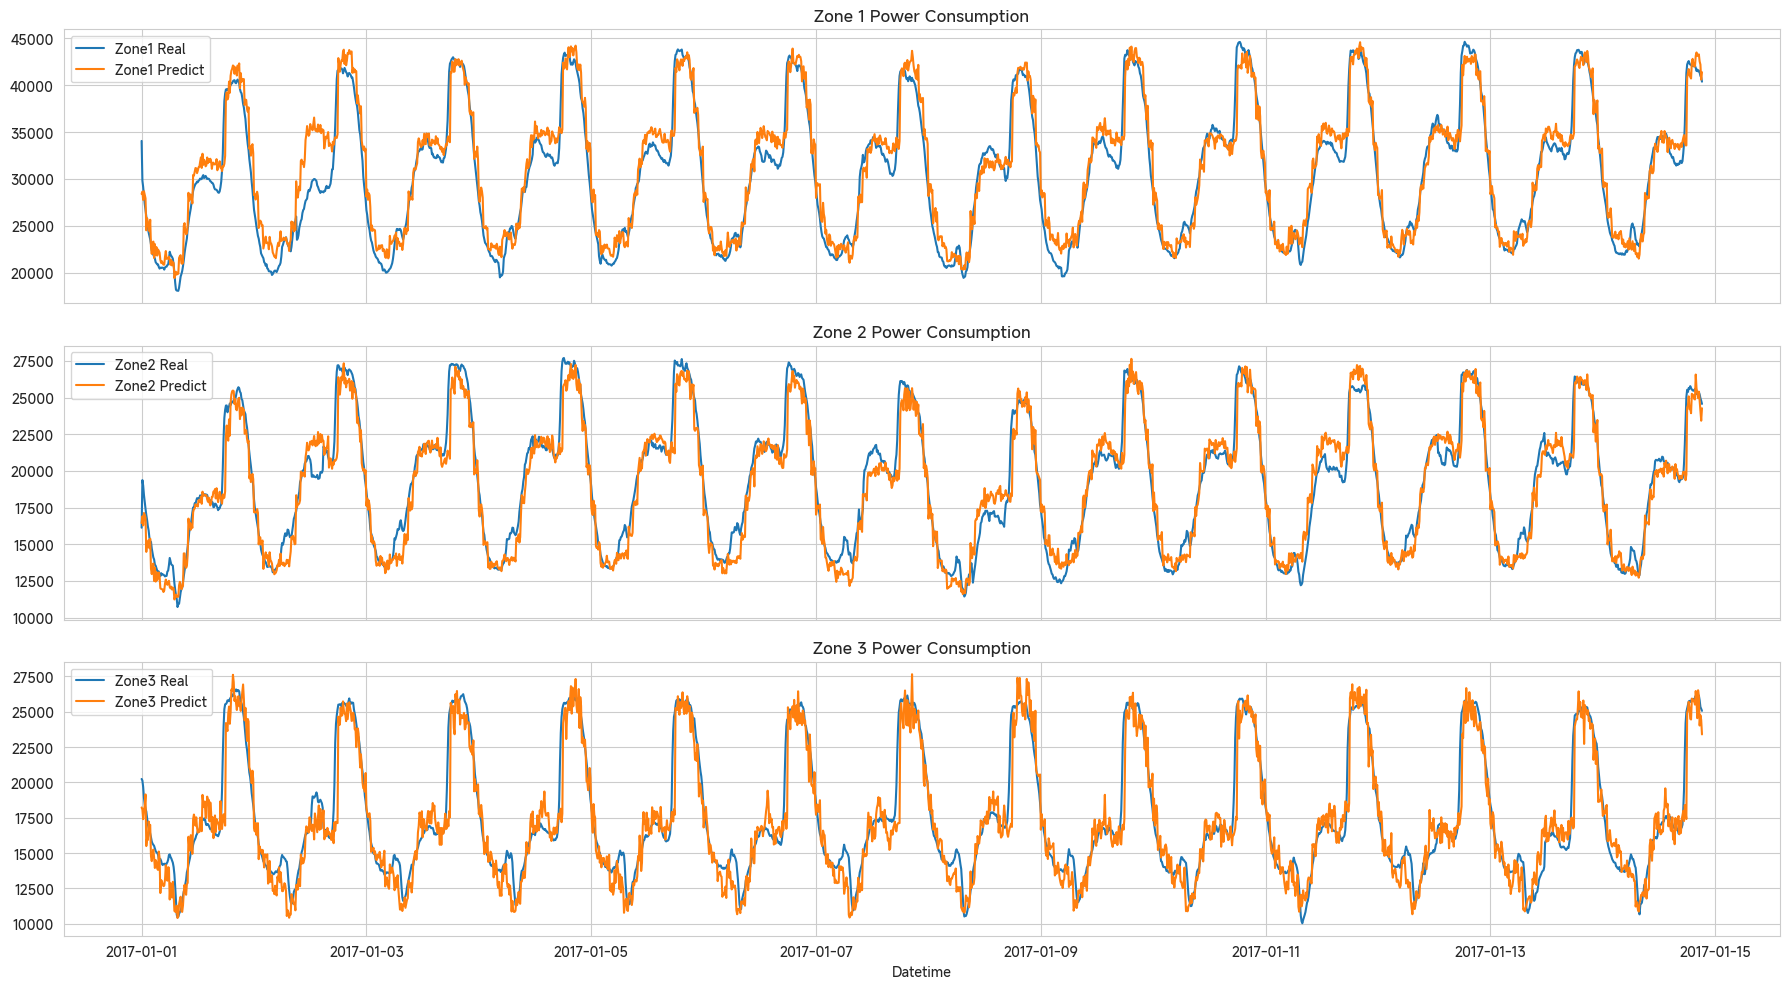

In [17]:
import matplotlib.pyplot as plt

# 采样（每隔10个取1个，前2000个）
df_sample = df.iloc[:2000]

# 创建子图
fig, axs = plt.subplots(3, 1, figsize=(18, 10), sharex=True)

# 区域1
axs[0].plot(df_sample['Datetime'], df_sample['PowerConsumption_Zone1'], label='Zone1 Real')
axs[0].plot(df_sample['Datetime'], df_sample['PowerConsumption_Zone1_Predict'], label='Zone1 Predict')
axs[0].set_title('Zone 1 Power Consumption')
axs[0].legend()

# 区域2
axs[1].plot(df_sample['Datetime'], df_sample['PowerConsumption_Zone2'], label='Zone2 Real')
axs[1].plot(df_sample['Datetime'], df_sample['PowerConsumption_Zone2_Predict'], label='Zone2 Predict')
axs[1].set_title('Zone 2 Power Consumption')
axs[1].legend()

# 区域3
axs[2].plot(df_sample['Datetime'], df_sample['PowerConsumption_Zone3'], label='Zone3 Real')
axs[2].plot(df_sample['Datetime'], df_sample['PowerConsumption_Zone3_Predict'], label='Zone3 Predict')
axs[2].set_title('Zone 3 Power Consumption')
axs[2].legend()

# 总体设置
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

In [18]:
!jupyter nbconvert --to html energy_CVAE4.ipynb 
# !jupyter nbconvert --to markdown energy_CVAE2.ipynb

[NbConvertApp] Converting notebook energy_CVAE4.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 2193853 bytes to energy_CVAE4.html
